In [1]:
print('What\'s up?')

What's up?


# Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
!pip install wordcloud
from wordcloud import WordCloud

# Constants

In [3]:
EXAMPLE_FILE = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/practice_email.txt'

SPAM_1_PATH = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/email-text-data.json'
WORD_ID_FILE = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/02_Training/train-data.txt'
TEST_DATA_FILE = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/02_Training/test-data.txt'

WHALE_FILE = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'C:/Users/bharg/OneDrive/Desktop/Naive Bayes Classifier/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [7]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [8]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [9]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = pd.concat([spam_emails, df_from_directory(SPAM_2_PATH, 1)], ignore_index=True)

spam_emails.head()

,MESSAGE,CATEGORY
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,##############################################...,1
4,I thought you might like these:\n\n1) Slim Dow...,1


In [12]:
spam_emails.shape

(1898, 2)

In [27]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = pd.concat([ham_emails, df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)], ignore_index=True)
ham_emails.shape

(3901, 2)

In [28]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,##############################################...,1
4,I thought you might like these:\n\n1) Slim Dow...,1


In [29]:
data.tail()

,MESSAGE,CATEGORY
3896,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
3897,"> >-- be careful when using this one.) Also, t...",0
3898,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
3899,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
3900,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning: Checking for Missing Values

In [30]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [31]:
type("")

str

In [32]:
len("")

0

In [33]:
my_var = None

In [34]:
type(my_var)

NoneType

In [35]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [36]:
(data.MESSAGE.str.len() == 0).sum()

3

In [37]:
# Challenge: how would you check the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [38]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [39]:
data[data.MESSAGE.str.len() == 0].index

Index([500, 1897, 2500], dtype='int64')

In [41]:
if '.DS_Store' in data.index:
    data = data.drop('.DS_Store')


In [42]:
data[4608:4611]

,MESSAGE,CATEGORY
2710,I have a strange problem with one user in a sm...,0
2711,"I just heard from Kevin Patrick Scannell, auth...",0
2712,"At 17:34 31/07/02 +0100, Liam Bedford wrote:\n...",0


# Remove System File Entries from Dataframe

In [48]:
# data.drop(['cmds', '.DS_Store'], inplace=True)

# data[4608:4611]

In [49]:
data.shape

(5799, 3)

# Add Document IDs to Track Emails in Dataset

In [50]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [51]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,1
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,2
3,##############################################...,1,3
4,I thought you might like these:\n\n1) Slim Dow...,1,4


In [52]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5794,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,5794
5795,"> >-- be careful when using this one.) Also, t...",0,5795
5796,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,5796
5797,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,5797
5798,"Hi there,\n\n\n\nNow this is probably of no us...",0,5798


# Save to File using Pandas

In [53]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [54]:
data.CATEGORY.value_counts()

CATEGORY
0    3901
1    1898
Name: count, dtype: int64

In [55]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

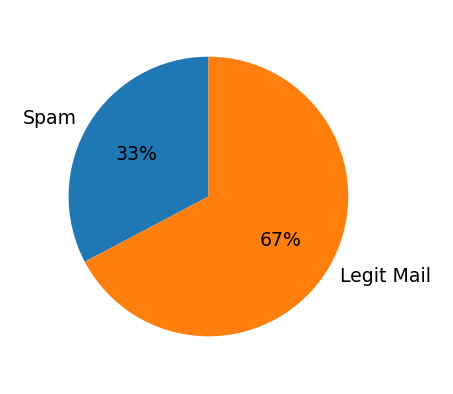

In [56]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%')
plt.show()

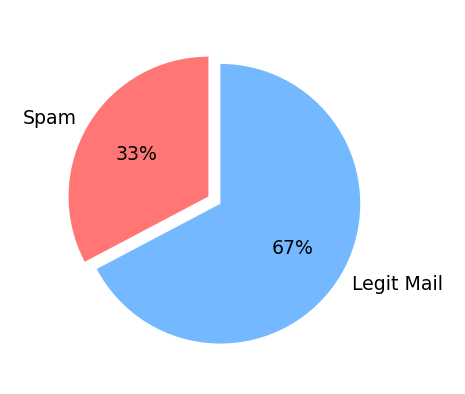

In [57]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

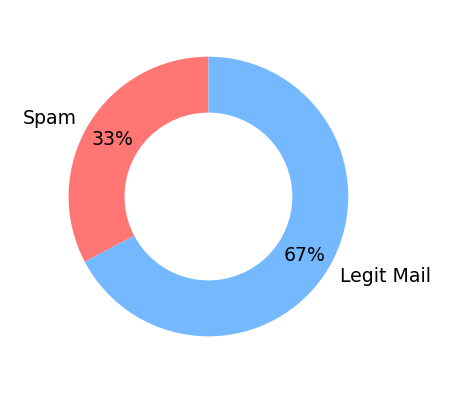

In [58]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

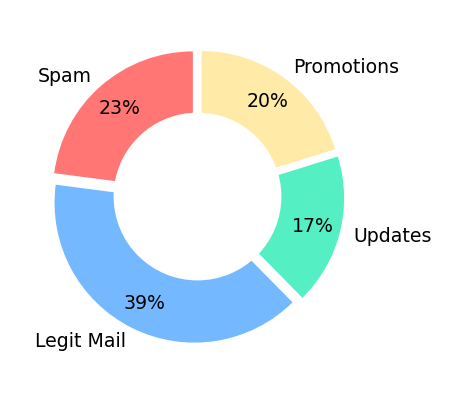

In [59]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing

In [60]:
# convert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [61]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [62]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [63]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\shakespeare.zip.


True

## Tokenising

In [64]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words 

In [66]:
stop_words = set(stopwords.words('english'))

In [67]:
type(stop_words)

set

In [68]:
if 'this' in stop_words: print('Found it!')

Found it!


In [69]:
# Challenge: print out 'Nope. Not in here' if the word "hello" is not contained in stop_words

In [70]:
if 'hello' not in stop_words: print('Nope. Not in here')

Nope. Not in here


In [71]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Stemming

In [72]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [73]:
'p'.isalpha()

True

In [74]:
'?'.isalpha()

False

In [75]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \
      Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [76]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [77]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Functions for Email Processing

In [78]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [79]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [80]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [81]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [82]:
data.iat[2, 2]

2

In [83]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,5
6,Help wanted. We are a 14 year old fortune 500...,1,6
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,7
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,8
9,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,9
10,Cellular Phone Accessories All At Below Wholes...,1,10


In [84]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [85]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

321

In [86]:
flat_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [92]:
# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\bharg\AppData\Local\Temp\ipykernel_19044\2639231389.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\bharg\AppData\Local\Temp\ipykernel_19044\2639231389.py:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [93]:
nested_list.tail()

DOC_ID
5794    [http, bizarr, collect, stuf, anim, could, fet...
5795    [care, use, one, also, realli, cute, thing, ja...
5796    [sm, skip, montanaro, write, jeremi, put, anot...
5797    [mark, hammond, like, given, zodb, sound, attr...
5798    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [94]:
data[data.CATEGORY == 1].shape

(1898, 3)

In [95]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1893,This is a multi-part message in MIME format.\n...,1,1893
1894,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,1894
1895,****Mid-Summer Customer Appreciation SALE!****...,1,1895
1896,ATTN:SIR/MADAN \n\n\n\n ...,1,1896
1897,,1,1897


In [96]:
# Challenge: create two variables (doc_ids_spam, doc_ids_ham) which 
# hold onto the indices for the spam and the non-spam emails respectively. 

In [97]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [98]:
doc_ids_ham

Index([1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
       ...
       5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798],
      dtype='int64', name='DOC_ID', length=3901)

### Subsetting a Series with an Index

In [99]:
type(doc_ids_ham)

pandas.core.indexes.base.Index

In [100]:
type(nested_list)

pandas.core.series.Series

In [101]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [102]:
nested_list_ham.shape

(3901,)

In [103]:
nested_list_ham.tail()

DOC_ID
5794    [http, bizarr, collect, stuf, anim, could, fet...
5795    [care, use, one, also, realli, cute, thing, ja...
5796    [sm, skip, montanaro, write, jeremi, put, anot...
5797    [mark, hammond, like, given, zodb, sound, attr...
5798    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [104]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [105]:
# Challenge: use python list comprehension and then find the total number of 
# words in our cleaned dataset of spam email bodies. Also find the total number of 
# words in normal emails in the dataset. Then find the 10 most common words used in 
# spam. Also, find the 10 most common words used in non-spam messages. 

In [106]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20815

In [107]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
Name: count, dtype: int64

In [108]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

13242

In [109]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
Name: count, dtype: int64

# Creating a Word Cloud

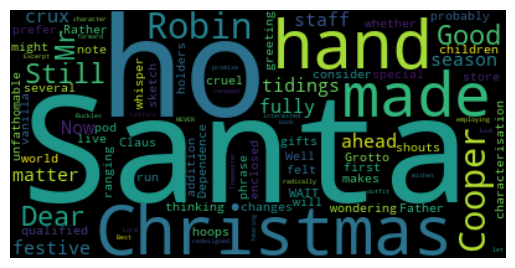

In [110]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [111]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [112]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [113]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [114]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

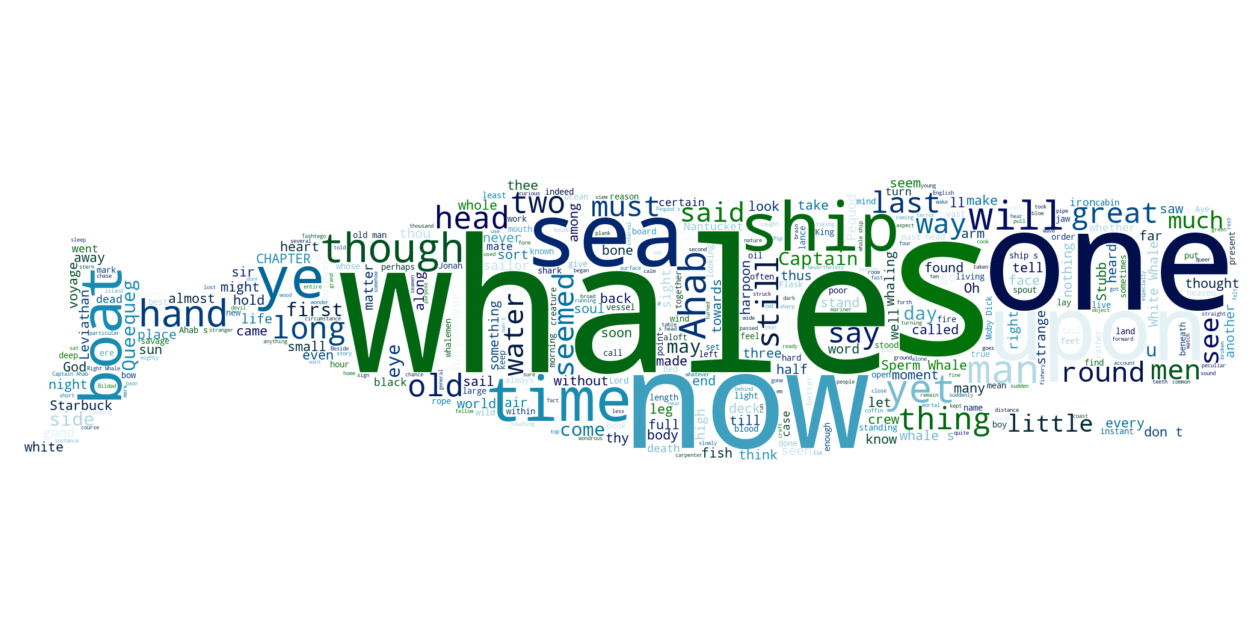

In [115]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=400, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [116]:
rgb_array.shape

(1024, 2048, 3)

In [117]:
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

In [118]:
rgb_array[500, 1000]

array([0, 0, 0], dtype=uint8)

In [119]:
# Challenge: use the skull image in the lesson resources to create a word cloud
# for Shakespeare's play Hamlet

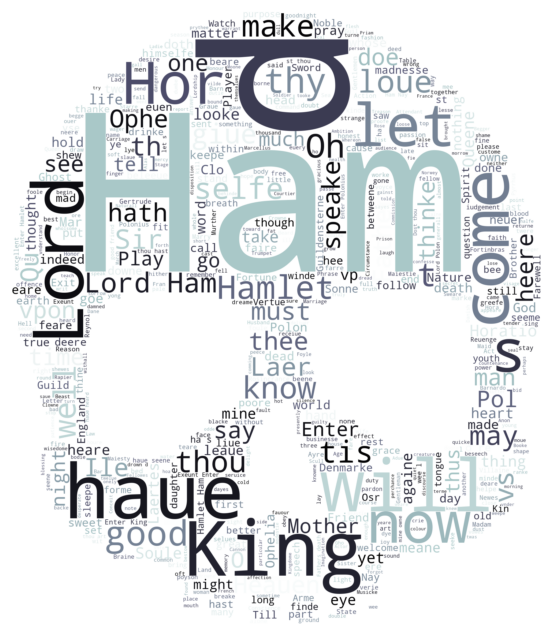

In [120]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      colormap='bone', max_words=600)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

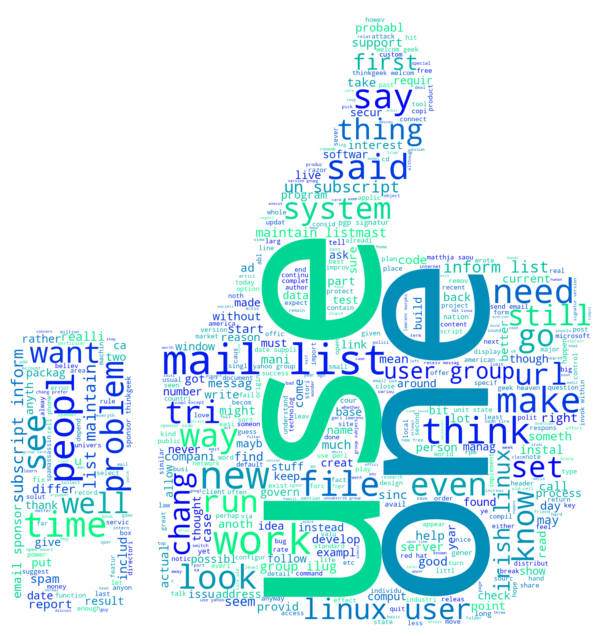

In [121]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [122]:
# Challenge: Look at the word cloud documentation. Use the custom font included in the 
# lesson resources instead of the default font and create a word cloud of the spammy words

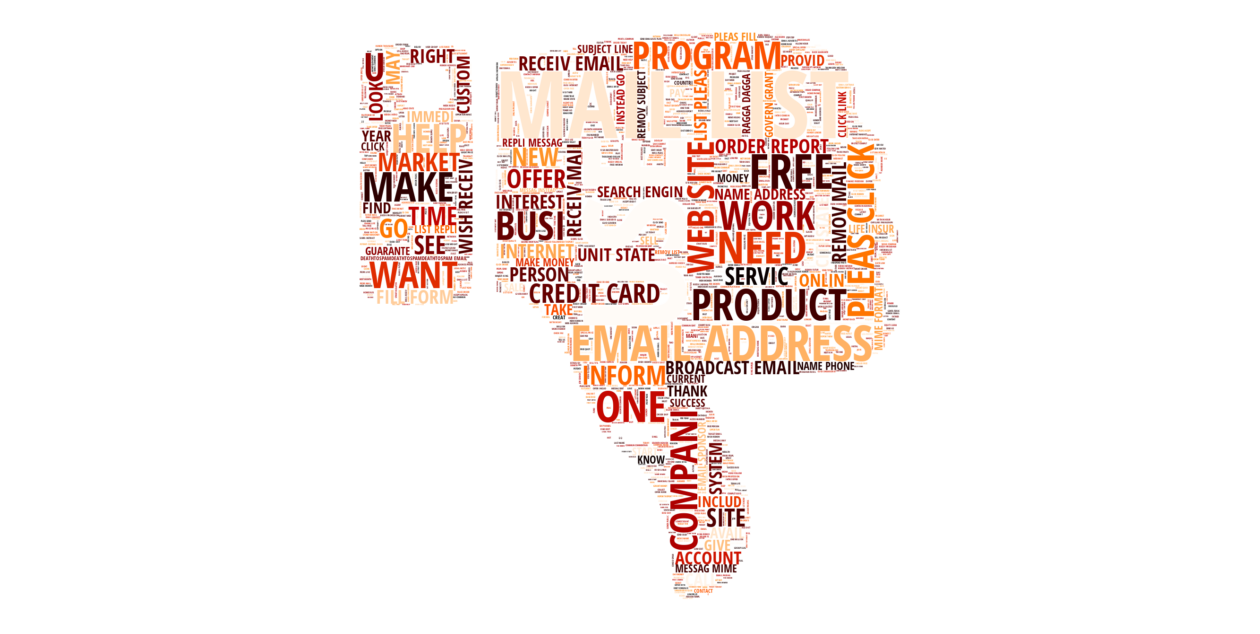

In [128]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [134]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\bharg\AppData\Local\Temp\ipykernel_19044\2639231389.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\bharg\AppData\Local\Temp\ipykernel_19044\2639231389.py:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [135]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
Name: count, dtype: int64

In [136]:
# Challenge: Create subset of the series called 'frequent_words' that only contains
# the most common 2,500 words out of the total. Print out the top 10 words

In [137]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [138]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [139]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of the Vocabulary

In [140]:
# Challenge: Write a line of code that checks if a particular word is part 
# of the vocabulary. Your code should return True if the word is among the 
# 2,500 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

In [141]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [142]:
'brew' in set(vocab.VOCAB_WORD) # better way

False

# Exercise: Find the Email with the Most Number of Words

In [143]:
# Challenge: Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data dataframe.

# Hint: use the len() function and practice list comprehension

In [144]:
# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [145]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))


Nr words in the longest email: 7671


In [146]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))


Email position in the list (and the data dataframe) 5778


In [147]:
stemmed_nested_list[np.argmax(clean_email_lengths)]


['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [148]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']


'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [149]:
type(stemmed_nested_list)

pandas.core.series.Series

In [150]:
type(stemmed_nested_list.tolist())

list

In [151]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [152]:
word_columns_df.shape

(5799, 7671)

### Splitting the Data into a Training and Testing Dataset

In [153]:
# Challenge: Can you split the data into a training and testing set? Set the test size at 30%. 
# The training data should include 4057 emails. Use a seed value of 42 to shuffle the data. 
# What should the target values be? 

In [154]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [155]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4059
Fraction of training set 0.6999482669425763


In [156]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4100,url,http,date,suppli,key,encod,photon,light,sent,kilometr,...,None,None,None,None,None,None,None,None,None,None
5233,dave,long,write,also,strike,long,livestock,genet,engin,dumber,...,None,None,None,None,None,None,None,None,None,None
5072,thu,jul,matthia,saou,wrote,upon,time,matthia,wrote,see,...,None,None,None,None,None,None,None,None,None,None
1293,creditfix,access,clear,bad,credit,onlin,directli,convieni,watch,credit,...,None,None,None,None,None,None,None,None,None,None
4357,us,lister,recognis,damian,lewi,winter,band,brother,annoy,one,...,None,None,None,None,None,None,None,None,None,None


In [157]:
y_train.head()


DOC_ID
4100    0
5233    0
5072    0
1293    1
4357    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [158]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [159]:
word_index.get_loc('thu')

393

In [160]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [ ]:
# %%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [ ]:
sparse_train_df[:5]

In [ ]:
sparse_train_df.shape

In [ ]:
sparse_train_df[-5:]

### Combine Occurrences with the Pandas groupby() Method

In [129]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              2
       7       1              1
       15      1              1
       18      1              1
       24      1              1

In [130]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [131]:
data.MESSAGE[0]

'Dear Homeowner,\n\n \n\nInterest Rates are at their lowest point in 40 years!\n\n\n\nWe help you find the best rate for your situation by\n\nmatching your needs with hundreds of lenders!\n\n\n\nHome Improvement, Refinance, Second Mortgage,\n\nHome Equity Loans, and More! Even with less than\n\nperfect credit!\n\n\n\nThis service is 100% FREE to home owners and new\n\nhome buyers without any obligation. \n\n\n\nJust fill out a quick, simple form and jump-start\n\nyour future plans today!\n\n\n\n\n\nVisit http://61.145.116.186/user0201/index.asp?Afft=QM10\n\n\n\n\n\n\n\n\n\n\n\n\n\nTo unsubscribe, please visit:\n\n\n\nhttp://61.145.116.186/light/watch.asp\n\n\n\n\n'

In [132]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,7,1,1
2,0,15,1,1
3,0,18,1,1
4,0,24,1,1


In [133]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
265378,5795,1535,0,2
265379,5795,1903,0,1
265380,5795,1905,0,2
265381,5795,2128,0,1
265382,5795,2279,0,1


In [134]:
vocab.at[1923, 'VOCAB_WORD']

'inbox'

In [135]:
data.MESSAGE[5795]

'If you run Pick, and then use the "New FTOC" button to show only\n\nthose messages selected by pick, then the ftoc display was considered\n\n"invalid" in the old code.  This prevented the display from being cached,\n\nand it meant that you could get back to the full folder display by\n\nclicking on the folder lablel.  That doesn\'t work anymore.  You have\n\nto resort to Rescan Folder.  In fact, when you change folders you\n\ncontinue to have the Pick results, not the new folder contents.\n\nIf you go to a any folder and do Rescan, then it heals itself.\n\n--\n\nBrent Welch\n\nSoftware Architect, Panasas Inc\n\nPioneering the World\'s Most Scalable and Agile Storage Network\n\nwww.panasas.com\n\nwelch@panasas.com\n\n\n\n\n\n\n\n\n\n_______________________________________________\n\nExmh-workers mailing list\n\nExmh-workers@redhat.com\n\nhttps://listman.redhat.com/mailman/listinfo/exmh-workers\n\n\n\n\n'

In [136]:
train_grouped.shape

(265383, 4)

### Save Training Data as .txt File

In [137]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [138]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# Challenge

Can you create a sparse matrix for the test data. Group the occurrences of the same word in the same email. Then save the data as a .txt file. 

In [139]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,could,tri,httrack,avail,http,recurs,grab,stuff,get,pictur,...,None,None,None,None,None,None,None,None,None,None
4220,adam,beberg,wrote,creator,didnt,say,could,without,pay,theft,...,None,None,None,None,None,None,None,None,None,None
2484,gari,lawrenc,murphi,wrote,say,hello,cool,oooo,go,caus,...,None,None,None,None,None,None,None,None,None,None
2418,wasnt,even,though,spellingi,oddli,familar,news,fork,randomis,letter,...,None,None,None,None,None,None,None,None,None,None
5110,gari,murphi,intend,take,legal,violent,action,peopl,world,away,...,None,None,None,None,None,None,None,None,None,None


In [140]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [141]:
X_test.shape

(1739, 7661)

In [142]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 2min 15s, sys: 858 ms, total: 2min 16s
Wall time: 2min 18s


In [143]:
sparse_test_df.shape

(187938, 4)

In [144]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,19,1,2
4,8,26,1,1


In [312]:
test_grouped.shape

(110307, 4)

In [311]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and Checking your Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing. 

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out.

In [313]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [316]:
len(test_doc_ids)

1723

In [318]:
len(X_test)

1739

In [321]:
set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing

{14,
 325,
 416,
 445,
 452,
 479,
 576,
 594,
 681,
 856,
 859,
 1001,
 1042,
 1096,
 1109,
 1407}

In [326]:
data.MESSAGE[14]

'------=_NextPart_000_00A3_65E24E1C.A3468E63\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nQ09QWSBEVkQgTU9WSUVTIFRPIENELVINClJJR0hUIE5PVyENCg0KDQpXZSBo\n\nYXZlIEFsbCB0aGUgc29mdHdhcmUgeW91IG5lZWQgdG8gQ09QWSB5b3VyIG93\n\nbiBEVkQgTW92aWVzLg0KDQpDb3B5IHlvdXIgb3duIERWRCBNb3ZpZXMgdXNp\n\nbmcgbm90aGluZyBtb3JlIHRoYW4gb3VyIHNvZnR3YXJlLCBhIA0KRFZELVJP\n\nTSBhbmQgeW91ciBDRC1SIGJ1cm5lciENCg0KQmFja3VwIHlvdXIgRFZEIE1v\n\ndmllIENvbGxlY3Rpb24gDQpQbGF5YmFjayBvbiBhbnkgaG9tZSBEVkQgcGxh\n\neWVyKiANCk5vIEV4cGVuc2l2ZSBEVkQgQnVybmVyIFJlcXVpcmVkIA0KRnJl\n\nZSBMaXZlIFRlY2ggU3VwcG9ydA0KDQogDQpMSU1JVEVEIFRJTUUgT0ZGRVIh\n\nIEZSRUUgRFZEIE1PVklFIE9GIFlPVVIgQ0hPSUNFISBBQ1QgTk9XIQ0KDQoN\n\nCjxhIGhyZWY9Imh0dHA6Ly8yMDIuMTA4LjIyMS4xOC93d3cyODIvcG9zL2R2\n\nZC5odG0iPmNsaWNrIGhlcmU8L2E+DQoNCisrKysrKysrKysrKysrKysrKysr\n\nKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysr\n\nKysrKysrKysrKysNClRoaXMgZW1haWwgaGFzIGJlZW4gc2NyZWVuZWQgYW5k\n\nIGZpbHRlcmVkIGJ5IG91ciBpb

In [327]:
data.loc[14]

CATEGORY                                                     1
MESSAGE      ------=_NextPart_000_00A3_65E24E1C.A3468E63\n\...
FILE_NAME               00095.17594a58d6736a8f6a1990b0b92090cd
Name: 14, dtype: object

In [329]:
clean_msg_no_html(data.at[14, 'MESSAGE'])

['kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr',
 'kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr']

In [331]:
data.MESSAGE[1096]

'<HTML><FONT  COLOR=3D"#ff00ff" BACK=3D"#ffffff" style=3D"BACKGROUND-COLOR: =\n\n#ffffff" SIZE=3D3 PTSIZE=3D12> &nbsp;<B><!--#rotate>Terific!!   Instantly =\n\n</FONT><FONT  COLOR=3D"#ff0000" BACK=3D"#ff80ff" style=3D"BACKGROUND-COLOR=\n\n: #ff80ff" SIZE=3D3 PTSIZE=3D12 FAMILY=3D"SANSSERIF" FACE=3D"Arial" LANG=3D=\n\n"0">S e x u a l l y Attract</FONT></FONT><FONT  COLOR=3D"#ff00ff" BACK=3D"=\n\n#ffffff" style=3D"BACKGROUND-COLOR: #ffffff" SIZE=3D3 PTSIZE=3D12 FAMILY=3D=\n\n"SANSSERIF" FACE=3D"Arial" LANG=3D"0"> with nature\'s secret weapon... Pher=\n\nomones!! &nbsp;&nbsp;*****<BR>\n\n<BR>\n\nInvisible and undetectable, when unknowingly inhaled, Pheromone Concentrat=\n\ne  unblocks all restraints and releases the raw  animal s e x drive!<BR>\n\n<BR>\n\nThis is the strongest concentration of </FONT><FONT  COLOR=3D"#ff0000" BAC=\n\nK=3D"#ff80ff" style=3D"BACKGROUND-COLOR: #ff80ff" SIZE=3D3 PTSIZE=3D12 FAM=\n\nILY=3D"SANSSERIF" FACE=3D"Arial" LANG=3D"0">HUMAN Pheromones</FONT></FONT>=\n\n

In [332]:
clean_msg_no_html(data.at[1096, 'MESSAGE'])

[]

In [334]:
clean_message(data.at[1096, 'MESSAGE'])

['html',
 'font',
 'ffffff',
 'ffffff',
 'nbsp',
 'b',
 'rotat',
 'terif',
 'instantli',
 'font',
 'sansserif',
 'arial',
 'e',
 'x',
 'u',
 'l',
 'l',
 'attract',
 'font',
 'ffffff',
 'ffffff',
 'sansserif',
 'arial',
 'natur',
 'secret',
 'weapon',
 'omon',
 'nbsp',
 'nbsp',
 'br',
 'br',
 'invis',
 'undetect',
 'unknowingli',
 'inhal',
 'pheromon',
 'e',
 'unblock',
 'restraint',
 'releas',
 'raw',
 'anim',
 'e',
 'x',
 'drive',
 'br',
 'br',
 'strongest',
 'concentr',
 'font',
 'sansserif',
 'arial',
 'human',
 'pheromon',
 'font',
 'ffffff',
 'ff',
 'sansserif',
 'arial',
 'allow',
 'law',
 'essenti',
 'oil',
 'br',
 'br',
 'avail',
 'formula',
 'men',
 'br',
 'br',
 'br',
 'learn',
 'font',
 'ffffff',
 'ffffff',
 'sansserif',
 'arial',
 'http',
 'click',
 'ttract',
 'br',
 'br',
 'br',
 'br',
 'br',
 'br',
 'br',
 'font',
 'ffffff',
 'ffffff',
 'sansserif',
 'arial',
 'br',
 'delet',
 'mail',
 'list',
 'pleas',
 'email',
 'us',
 'delet',
 'font',
 'ffff',
 'ffffff',
 'ansserif',
